### Introduction

**What is Spatial Querying?** 🧭
Spatial querying is the process of retrieving data based on its spatial relationships.
Think of a spatial query like asking a question about location. Instead of a traditional query that might ask "what are all the cells with an area greater than X?", a spatial query asks questions like:

"Which nuclei are contained within or intersect with this specific region?"

Essentially, you're using location to filter and select your data. This is a fundamental concept in geospatial analysis, whether you're working with satellite imagery or, in this case, histological whole-slide images (WSIs).

Since Histolytics' panoptic segmentation outputs are typically stored in vectorized format (GeoParquet files) instead of dense raster masks, spatial querying can be performed more efficiently and flexibly at WSI-scale.

Next we'll demonstrate the most useful queries in Histolytics. We will be using a segmented cervix biopsy dataset as an example.

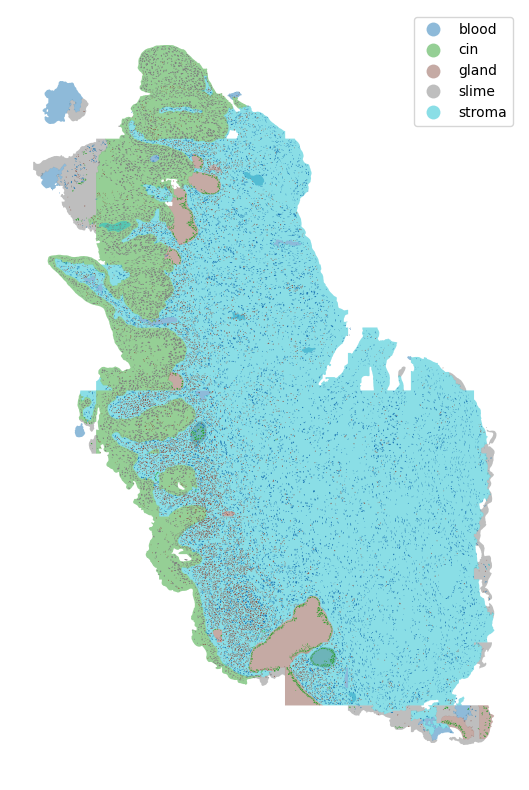

In [1]:
# Let's load some data to play around with
import matplotlib.pyplot as plt
from histolytics.data import cervix_nuclei, cervix_tissue

tis = cervix_tissue()
nuc = cervix_nuclei()

fig, ax = plt.subplots(figsize=(10, 10))
tis.plot(ax=ax, column="class_name", aspect=1, alpha=0.5, legend=True)
nuc.plot(ax=ax, column="class_name", aspect=1, legend=False)
ax.set_axis_off()

In [2]:
# Let's check what nuclei types and tissue types are present
print("Nuclei types:")
print(nuc["class_name"].unique())
print("Tissue types:")
print(tis["class_name"].unique())

Nuclei types:
['connective' 'squamous_epithel' 'glandular_epithel' 'inflammatory'
 'neoplastic']
Tissue types:
['stroma' 'cin' 'slime' 'blood' 'gland']


### Query 1: Nuclei Within a Specific Region

Next we'll show how to query cells/nuclei contained strictly within a specific region using spatial querying. The `get_objs` function is the workhorse to perform these queries. It uses the powerful R-Tree spatial index provided by `geopandas` to efficiently find geometries that meet our criteria.

1. We will query for neoplastic cells within a neoplastic lesion (CIN) of a cervix biopsy.
2. We will query inflammatory cells within the stromal region of the cervix biopsy.

,geometry,class_name
23,"POLYGON ((944 4701.02, 939.83 4703.17, 936.01 ...",neoplastic
25,"POLYGON ((751.75 5549, 751.01 5549.02, 750.01 ...",neoplastic
26,"POLYGON ((916 4754.02, 912.01 4756.02, 909.01 ...",neoplastic
47,"POLYGON ((776 8326.02, 775.01 8327, 775.01 834...",neoplastic
173,"POLYGON ((1947 4664.02, 1946.01 4665, 1946.01 ...",neoplastic


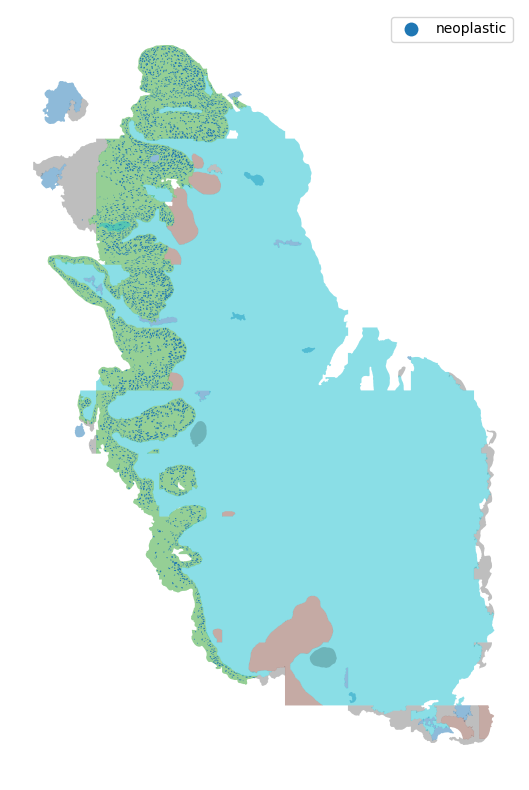

In [3]:
from histolytics.spatial_ops import get_objs

# get the CIN tissue and neoplastic nuclei
cin_tissue = tis[tis["class_name"] == "cin"]
neo_nuclei = nuc[nuc["class_name"] == "neoplastic"]

# select all the neoplastic nuclei contained within CIN tissue
neo_within_cin = get_objs(cin_tissue, neo_nuclei, predicate="contains")

ax = tis.plot(figsize=(10, 10), column="class_name", aspect=1, alpha=0.5, legend=False)
neo_within_cin.plot(ax=ax, column="class_name", aspect=1, legend=True)
ax.set_axis_off()
neo_within_cin.head()

,geometry,class_name
14,"POLYGON ((925 5211.02, 924.01 5212, 924.01 522...",inflammatory
17,"POLYGON ((899 5607.02, 898.01 5608, 898.01 561...",inflammatory
22,"POLYGON ((873 5284.02, 871.01 5286, 871.01 529...",inflammatory
29,"POLYGON ((974.75 5432, 974.01 5432.02, 973.01 ...",inflammatory
31,"POLYGON ((960.75 5540, 956 5540.02, 955.01 554...",inflammatory


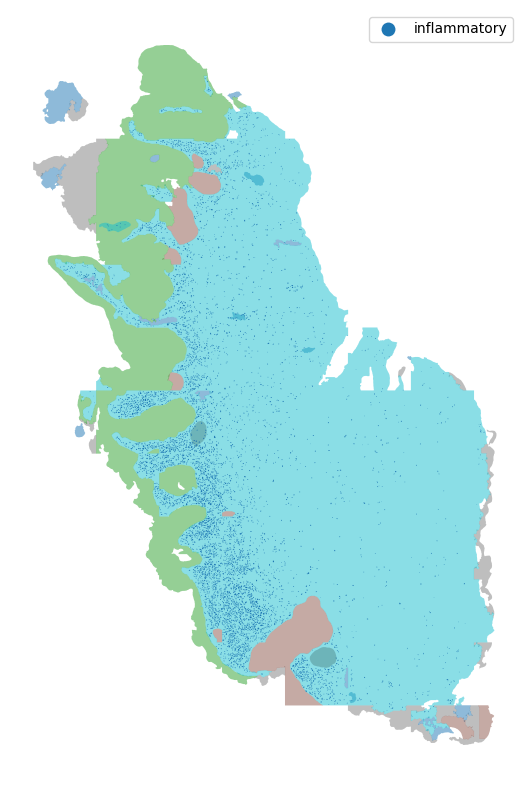

In [4]:
from histolytics.spatial_ops import get_objs

# get the stroma tissue and inflammatory nuclei
stroma_tissue = tis[tis["class_name"] == "stroma"]
infl_nuclei = nuc[nuc["class_name"] == "inflammatory"]

# select all the nuclei contained within stroma tissue
infl_within_stroma = get_objs(stroma_tissue, infl_nuclei, predicate="contains")

ax = tis.plot(figsize=(10, 10), column="class_name", aspect=1, alpha=0.5, legend=False)
infl_within_stroma.plot(ax=ax, column="class_name", aspect=1, legend=True)
ax.set_axis_off()
infl_within_stroma.head()

### Query 2: Nuclei Intersecting with a Specific Region

Typically we don't want to constrain the queries to nuclei that reside strictly within a specific region but rather use the more loose 'intersects' predicate. This includes nuclei that intersect with the region's boundaries. Next we'll:

1. Query for neoplastic cells within a stroma of a cervix biopsy. If the segmentation maps would be perfect, this would be an effective way to find metastasizing cells or just neoplastic cells residing at the tissue boundary.
2. Query inflammatory cells within the CIN lesion region of the cervix biopsy. This is an efficient way to detect TILs (tumor-infiltrating lymphocytes).

,geometry,class_name
25,"POLYGON ((751.75 5549, 751.01 5549.02, 750.01 ...",neoplastic
26,"POLYGON ((916 4754.02, 912.01 4756.02, 909.01 ...",neoplastic
47,"POLYGON ((776 8326.02, 775.01 8327, 775.01 834...",neoplastic
48,"POLYGON ((702 7641.02, 697.01 7643.02, 694.01 ...",neoplastic
64,"POLYGON ((709.25 8292, 707.01 8293.02, 705.01 ...",neoplastic


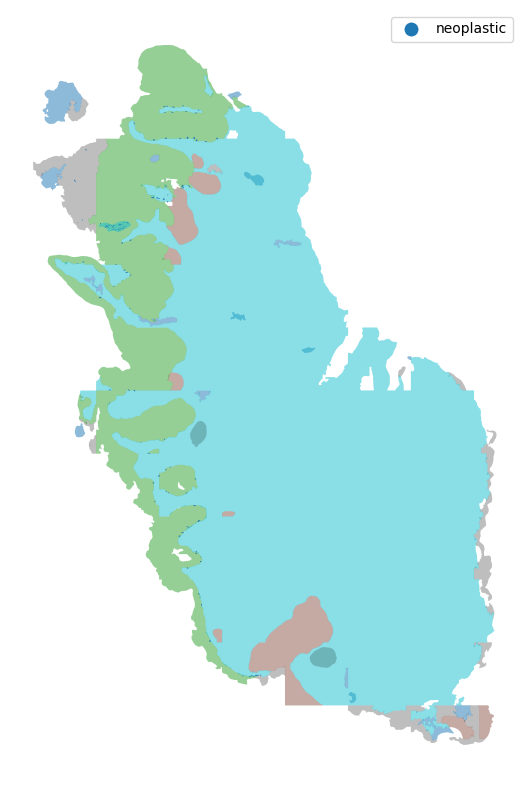

In [5]:
# get the stroma tissue and neoplastic nuclei
stroma_tissue = tis[tis["class_name"] == "stroma"]
infl_nuclei = nuc[nuc["class_name"] == "neoplastic"]

# select all the nuclei contained within CIN tissue
neo_inter_stroma = get_objs(stroma_tissue, infl_nuclei, predicate="intersects")

ax = tis.plot(figsize=(10, 10), column="class_name", aspect=1, alpha=0.5, legend=False)
neo_inter_stroma.plot(ax=ax, column="class_name", aspect=1, legend=True)
ax.set_axis_off()
neo_inter_stroma.head()

,geometry,class_name
14,"POLYGON ((925 5211.02, 924.01 5212, 924.01 522...",inflammatory
17,"POLYGON ((899 5607.02, 898.01 5608, 898.01 561...",inflammatory
22,"POLYGON ((873 5284.02, 871.01 5286, 871.01 529...",inflammatory
29,"POLYGON ((974.75 5432, 974.01 5432.02, 973.01 ...",inflammatory
33,"POLYGON ((987 7560.02, 985.01 7561.02, 983.01 ...",inflammatory


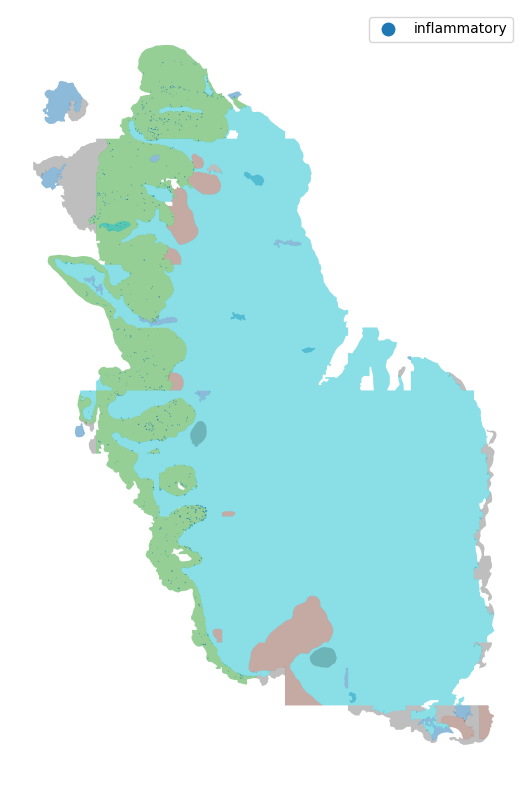

In [6]:
# get the CIN tissue and inflammatory nuclei
cin_tissue = tis[tis["class_name"] == "cin"]
infl_nuclei = nuc[nuc["class_name"] == "inflammatory"]

# select all the inflammatory nuclei intersecting within CIN tissue
infl_inter_cin = get_objs(cin_tissue, infl_nuclei, predicate="intersects")

ax = tis.plot(figsize=(10, 10), column="class_name", aspect=1, alpha=0.5, legend=False)
infl_inter_cin.plot(ax=ax, column="class_name", aspect=1, legend=True)
ax.set_axis_off()
infl_inter_cin.head()

### Benchmarking

Instead of looping patches and finding inflammatory nuclei from each raster patch, the spatial indexing based querying can significantly speed up the process. For example, the last query we did takes less than 20ms on a regular laptop.

In [7]:
%%timeit

# get the CIN tissue and inflammatory nuclei
cin_tissue = tis[tis["class_name"] == "cin"]
infl_nuclei = nuc[nuc["class_name"] == "inflammatory"]

# select all the inflammatory nuclei intersecting within CIN tissue
infl_inter_cin = get_objs(cin_tissue, infl_nuclei, predicate="intersects")

14.9 ms ± 453 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
